# Artportalen Age Classification with ResNet152

This notebook demonstrates age classification on the Artportalen Golden Eagle dataset using a ResNet152 model.

## Overview
- Load Artportalen dataset with segmentations
- Train a ResNet152 model for age classification
- Evaluate the model performance
- Visualize results with GradCAM

In [1]:
# Import necessary libraries
import sys
import os
sys.path.append('../')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import timm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import wandb

# Set random seeds for reproducibility
pl.seed_everything(42)
torch.manual_seed(42)
np.random.seed(42)

Seed set to 42


In [3]:
# Load the Artportalen dataset
from data.artportalen_goleag import ArtportalenDataModule
from data.data_utils import unnormalize

# Configuration
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
data_dir = '/Users/amee/Documents/code/master-thesis/datasets/artportalen_goeag'
cache_dir = '/Users/amee/Documents/code/master-thesis/EagleID/dataset/artportalen_cache'

# Create data module
datamodule = ArtportalenDataModule(
    data_dir=data_dir,
    batch_size=16,
    size=224,
    mean=mean,
    std=std,
    cache_dir=cache_dir,
    preprocess_lvl=2  # Use masked images for better classification
)

# Setup the dataset
datamodule.setup_from_csv(
    '/Users/amee/Documents/code/master-thesis/AgeClassifier/annot/final_train_sep_sightings.csv',
    '/Users/amee/Documents/code/master-thesis/AgeClassifier/annot/final_val_sep_sightings.csv'
)

print(f"Number of classes: {datamodule.num_classes}")
print(f"Training samples: {len(datamodule.train_dataset)}")
print(f"Validation samples: {len(datamodule.val_dataset)}")

Train: 2362 Val: 3482
Unique classes in dataset: [1 3 2 4 5]
Number of classes: 5
Number of classes: 5
Training samples: 2362
Validation samples: 3482


Batch shape: torch.Size([16, 3, 256, 256])
Labels: tensor([2, 1, 0, 2, 1, 4, 2, 4, 1, 4, 0, 1, 4, 1, 2, 0])


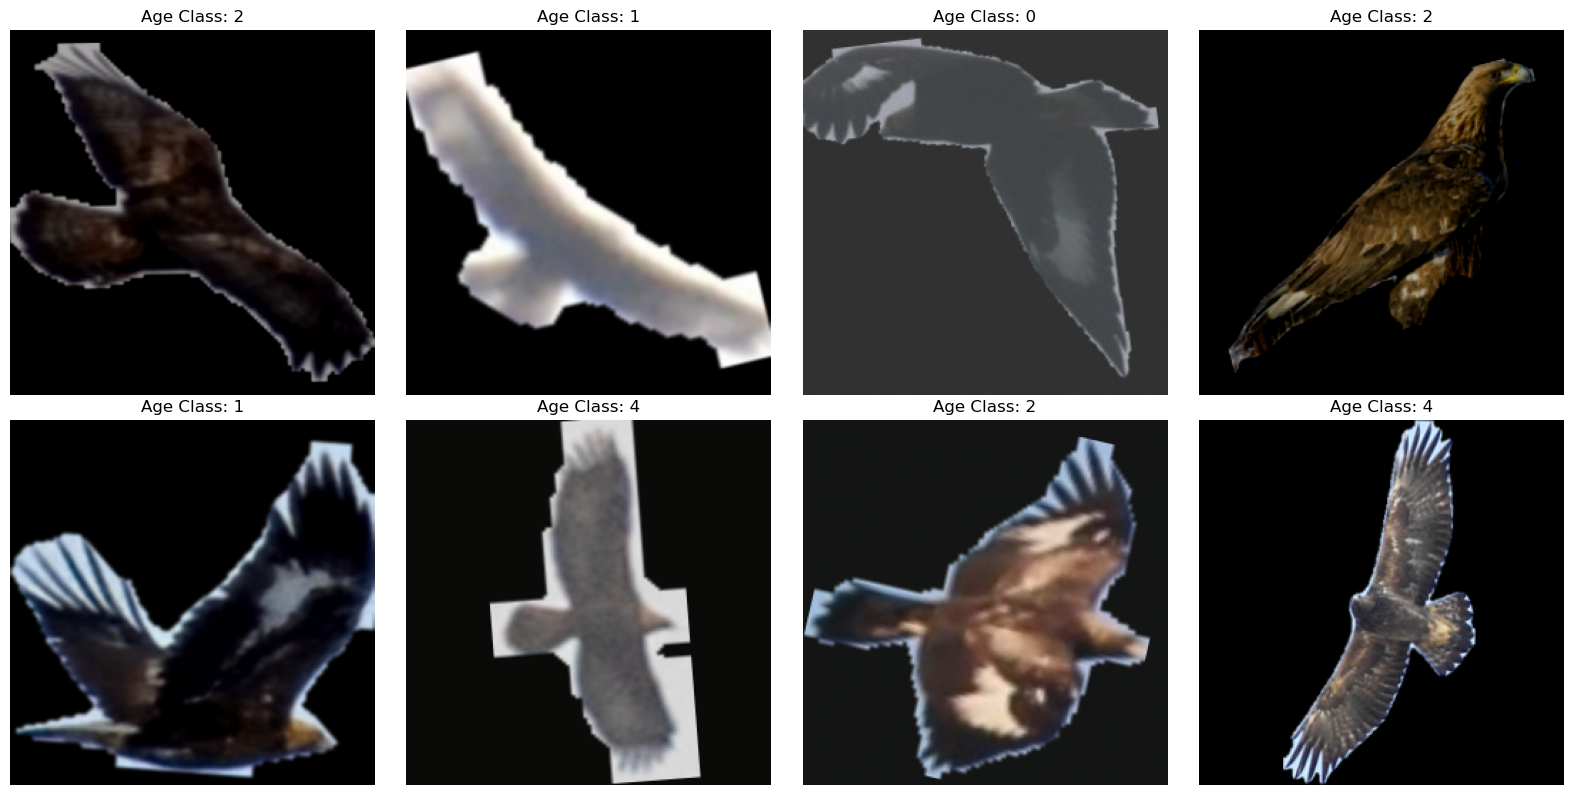

In [4]:
# Visualize some samples from the dataset
train_loader = datamodule.train_dataloader()
batch = next(iter(train_loader))
images, labels = batch

print(f"Batch shape: {images.shape}")
print(f"Labels: {labels}")

# Plot sample images
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(min(8, len(images))):
    # Unnormalize the image
    img_np = unnormalize(images[i], mean, std).permute(1, 2, 0).numpy()
    img_np = np.clip(img_np, 0, 1)
    
    axes[i].imshow(img_np)
    axes[i].set_title(f'Age Class: {labels[i].item()}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Define the ResNet152 model for age classification
class AgeClassificationModel(pl.LightningModule):
    def __init__(self, num_classes=5, learning_rate=1e-4):
        super().__init__()
        self.save_hyperparameters()
        
        # Load ResNet152 pretrained model
        self.model = timm.create_model(
            'resnet152', 
            pretrained=True, 
            num_classes=num_classes
        )
        
        # Loss function and metrics
        self.criterion = nn.CrossEntropyLoss()
        self.train_acc = pl.metrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.val_acc = pl.metrics.Accuracy(task='multiclass', num_classes=num_classes)
        
        # Store predictions for confusion matrix
        self.val_preds = []
        self.val_targets = []
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.train_acc(logits.softmax(dim=-1), y)
        
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.val_acc(logits.softmax(dim=-1), y)
        
        # Store predictions for confusion matrix
        preds = logits.argmax(dim=-1)
        self.val_preds.extend(preds.cpu().numpy())
        self.val_targets.extend(y.cpu().numpy())
        
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        
        return loss
    
    def on_validation_epoch_end(self):
        # Calculate confusion matrix
        if len(self.val_preds) > 0:
            cm = confusion_matrix(self.val_targets, self.val_preds)
            self.logger.experiment.add_figure('confusion_matrix', self.plot_confusion_matrix(cm), self.current_epoch)
            
            # Reset for next epoch
            self.val_preds = []
            self.val_targets = []
    
    def plot_confusion_matrix(self, cm):
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title('Confusion Matrix')
        return fig
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.learning_rate, weight_decay=0.01)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
            },
        }

In [ ]:
# Initialize the model
model = AgeClassificationModel(
    num_classes=datamodule.num_classes,
    learning_rate=1e-4
)

# Print model summary
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

In [ ]:
# Setup callbacks and logger
checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',
    dirpath='../checkpoints/artportalen_age_classification',
    filename='resnet152-age-{epoch:02d}-{val_acc:.3f}',
    save_top_k=3,
    mode='max',
    save_last=True
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min'
)

logger = TensorBoardLogger("../logs", name="artportalen_age_classification")

# Initialize trainer
trainer = pl.Trainer(
    max_epochs=50,
    accelerator='auto',
    devices=1,
    callbacks=[checkpoint_callback, early_stopping],
    logger=logger,
    log_every_n_steps=10,
    precision=16,  # Use mixed precision for faster training
    gradient_clip_val=1.0
)

In [ ]:
# Train the model
print("Starting training...")
trainer.fit(model, datamodule)
print("Training completed!")

In [ ]:
# Load the best model
best_model_path = checkpoint_callback.best_model_path
print(f"Best model path: {best_model_path}")

best_model = AgeClassificationModel.load_from_checkpoint(best_model_path)
best_model.eval()

In [ ]:
# Evaluate on validation set
val_loader = datamodule.val_dataloader()
all_preds = []
all_targets = []
all_probs = []

with torch.no_grad():
    for batch in val_loader:
        x, y = batch
        logits = best_model(x)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)
all_probs = np.array(all_probs)

# Calculate metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

accuracy = accuracy_score(all_targets, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_preds, average='weighted')

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Age 1', 'Age 2', 'Age 3', 'Age 4', 'Age 5'],
            yticklabels=['Age 1', 'Age 2', 'Age 3', 'Age 4', 'Age 5'])
plt.title('Confusion Matrix - Age Classification')
plt.xlabel('Predicted Age')
plt.ylabel('Actual Age')
plt.show()

In [ ]:
# Print detailed classification report
print("Classification Report:")
print(classification_report(all_targets, all_preds, 
                          target_names=['Age 1', 'Age 2', 'Age 3', 'Age 4', 'Age 5']))

In [ ]:
# Visualize some predictions
val_loader = datamodule.val_dataloader()
batch = next(iter(val_loader))
images, targets = batch

with torch.no_grad():
    logits = best_model(images)
    probs = torch.softmax(logits, dim=1)
    preds = torch.argmax(logits, dim=1)

# Plot results
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(min(8, len(images))):
    # Unnormalize the image
    img_np = unnormalize(images[i], mean, std).permute(1, 2, 0).numpy()
    img_np = np.clip(img_np, 0, 1)
    
    axes[i].imshow(img_np)
    
    # Get prediction and confidence
    pred = preds[i].item()
    target = targets[i].item()
    confidence = probs[i][pred].item()
    
    # Color code the title
    color = 'green' if pred == target else 'red'
    axes[i].set_title(f'Pred: Age {pred+1} ({confidence:.2f})\nTrue: Age {target+1}', 
                     color=color, fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# GradCAM visualization for model interpretability
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

def visualize_gradcam(model, image, target_class, mean, std):
    """Visualize GradCAM for a given image and target class."""
    # Set up GradCAM
    target_layers = [model.model.layer4[-1]]
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available())
    
    # Prepare input
    input_tensor = image.unsqueeze(0)
    targets = [ClassifierOutputTarget(target_class)]
    
    # Generate CAM
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    
    # Prepare image for visualization
    img_np = unnormalize(image, mean, std).permute(1, 2, 0).numpy()
    img_np = np.clip(img_np, 0, 1)
    
    # Overlay CAM on image
    visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
    
    return img_np, grayscale_cam, visualization

# Visualize GradCAM for a few samples
val_loader = datamodule.val_dataloader()
batch = next(iter(val_loader))
images, targets = batch

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for i in range(min(9, len(images))):
    image = images[i]
    target = targets[i].item()
    
    # Get prediction
    with torch.no_grad():
        logits = best_model(image.unsqueeze(0))
        pred = torch.argmax(logits, dim=1).item()
    
    # Generate GradCAM
    img_np, cam, visualization = visualize_gradcam(best_model, image, pred, mean, std)
    
    # Plot
    axes[i].imshow(visualization)
    axes[i].set_title(f'Pred: Age {pred+1}, True: Age {target+1}', fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Save the trained model
torch.save(best_model.state_dict(), '../models/artportalen_age_classification_resnet152.pth')
print("Model saved successfully!")

## Summary

This notebook demonstrates:

1. **Data Loading**: Successfully loaded the Artportalen dataset with segmentations
2. **Model Architecture**: Used ResNet152 for age classification
3. **Training**: Trained the model with proper callbacks and logging
4. **Evaluation**: Comprehensive evaluation with confusion matrix and classification report
5. **Visualization**: GradCAM for model interpretability

The model can be further improved by:
- Using data augmentation
- Trying different architectures
- Ensemble methods
- Hyperparameter tuning